In [ ]:
import pandas as pd
pd.set_option('max_colwidth',150)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from string import punctuation
import re
import os
from sklearn.feature_extraction.text import CountVectorizer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # allow multiple outputs in a cell
import warnings
import pandas as pd
# pd.options.plotting.backend = "plotly"
# warnings.filterwarnings("ignore")
%matplotlib inline

# Download and Extract the Datasets

In [ ]:
# Downloading all-the-news-2-news-articles-dataset 
! wget https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0

# Downloading Annotated Corpus for Named Entity Recognition dataset
!gdown https://drive.google.com/uc?id=13y8JNgL5TQ4x-yufpBOv3QBsEiE051sE

# Make a data folder to store the data
!mkdir data

!unzip /content/all-the-news-2-1.zip?dl=0 -d ./data/

!mv /content/ner.csv ./data

!rm /content/all-the-news-2-1.zip?dl=0



--2022-09-27 00:01:07--  https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip [following]
--2022-09-27 00:01:08--  https://www.dropbox.com/s/raw/cn2utnr5ipathhh/all-the-news-2-1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd1eb56254080076d87ad935b4e.dl.dropboxusercontent.com/cd/0/inline/BttzWM0Eq4JTbk3BOhZpWiTsWDJIkKq49A83yVMABV23_R72tCOrGhFG_LjYAlXxsmUHqqRIX4qVQNIyuDTsPEGwHcVwUyKk1F2VALItD1cxd8Jd36xe3Pa77HSbWx_S2XCPf021R9NAYyXisGj8yb5S89yNZs9oc8rHIvrPTHprnA/file# [following]
--2022-09-27 00:01:08--  https://ucd1eb56254080076d87ad935b4e.dl.dropboxusercontent.com/cd/0/inline/BttzWM0Eq4JTbk3BOhZpWiTsWDJIkKq49A83yVMABV23_R72

# Load Data

In [ ]:
#specify the path to data location

filepath = '/content/data/all-the-news-2-1.csv'
# data = pd.read_csv(filepath, encoding = "ISO-8859-1")
data = pd.read_csv(filepath, encoding = "utf-8")  


In [ ]:
#Verify that the data is loaded correctly
data.head(3)

,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of liberal democracy seriously,"This post is part of Polyarchy, an independent blog produced by the political reform program at New America, a Washington think tank devoted to de...",https://www.vox.com/polyarchy/2016/12/9/13898340/democracy-warning-signs,NaN,Vox
1,2016-10-07 21:26:46,2016,10.0,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contract makes it difficult to build the team,"The Indianapolis Colts made Andrew Luck the highest-paid player in NFL history this offseason with a five-year, $122-million contract with $89 mi...",https://www.businessinsider.com/colts-gm-ryan-grigson-andrew-luck-contract-2016-10,NaN,Business Insider
2,2018-01-26 00:00:00,2018,1.0,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President Donald Trump denied a report on Friday that he had ordered Special Counsel Robert Mueller fired last...",https://www.reuters.com/article/us-davos-meeting-trump-mueller/trump-denies-report-he-ordered-mueller-fired-idUSKBN1FF12A,Davos,Reuters



## Load the data which focus only on Health and Technology Section


In [ ]:
def filter_section(section):

  if str(section).lower().startswith('tech') :
    return 'technology'
  elif str(section).lower().startswith('health'):
    return 'health'

  return 'other'

In [ ]:
data['tech_health_tag'] = data['section'].apply(filter_section)

In [ ]:
data_tech_health = data[(data['tech_health_tag']=='technology') |  (data['tech_health_tag']=='health')]

In [ ]:
data_tech_health = data_tech_health.reset_index(drop=True)

In [ ]:
data_tech_health.head(3)

,date,year,month,day,author,title,article,url,section,publication,tech_health_tag
0,2018-05-02 17:09:00,2018,5.0,2,Caroline Williams,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’t put your finger on why: Maybe you had just the right amount of sleep. Maybe the stars are somehow ...,https://www.vice.com/en_us/article/9kgp4v/how-to-improve-focus-be-more-creative,Health,Vice,health
1,2018-10-05 19:35:00,2018,10.0,5,Caroline Haskins,Trash Geyser Spews Garbage In Yellowstone National Park,"Geyser eruptions are known as one of the most beautiful events to occur in nature. Not anymore! On September 15, Yellowstone Park’s Ear Spring ge...",https://www.vice.com/en_us/article/evwq47/ear-spring-geyser-spews-trash-in-yellowstone-national-park,Tech by VICE,Vice,technology
2,2019-06-20 00:00:00,2019,6.0,20,Gergely Szakacs,"Hungary has no evidence of Huawei threat, plans rapid 5G rollout: minister","BUDAPEST (Reuters) - Hungary has no evidence that equipment from Chinese telecoms giant Huawei poses a security threat, a government minister said...",https://www.reuters.com/article/us-hungary-telecoms-5g-huawei/hungary-has-no-evidence-of-huawei-threat-plans-rapid-5g-rollout-minister-idUSKCN1TL2AP,Technology News,Reuters,technology


## Data Cleaning

In [ ]:
def processed_text_article(df):
    special_char = list(punctuation)
    for e in ['.','?']:
        special_char.remove(e)
    special_char.append("\n+")
    special_char.append("\s+")

    def deep_clean(text_str):
      text_str = str(text_str)
      text_str =text_str.strip()
      text_str = re.sub('<[^>]*>', '', text_str)
      for char in special_char:
          text_str = text_str.replace(char, '')
      return text_str

    df['article'] = df['article'].apply(deep_clean)
    df['title'] = df['title'].apply(deep_clean)
    return df

def clean_dataFrame(df):
  missing_cols = df.isnull().sum()
  drop_missing_cols = missing_cols[(missing_cols > len(df)/20)].sort_values()
  df = df.drop(drop_missing_cols.index, axis=1)
  df['date'] = pd.to_datetime(df['date'])
  df = df.dropna()
  #reset index
  df = df.reset_index(drop=True)
  # make all columns lower_case 
  df.columns = df.columns.str.lower()
  df = processed_text_article(df)
  return df

In [ ]:
data_tech_health = clean_dataFrame(data_tech_health)

## Topic Modeling

In [ ]:
#data_tech.head()
data_text = data_tech_health[['article']].sample(2000)
data_text['index'] = data_text.index
documents = data_text

In [ ]:
print(len(documents))


2000


In [ ]:
print(documents[0:5])

                                                                                                                                                     article  \
83736  Talk about a special delivery. In the wee hours of April 19 a custommade drone roughly the size of a washing machine lifted off from a neighborhoo...   
96816  LONDON Reuters  Evidence is weak for whether medicinal cannabis treatments can relieve mental illnesses such as anxiety depression and psychosis a...   
39057  Nov 8 Reuters  Evotec Ag  9M revenue rose 42 percent to 170.9 million eur  ‍9M adjusted group EBITDA up 28 to eur 39.3 m 9m 2016 eur 30.6 m​  Says...   
29691  Former Miss America Mallory Hagan is running for Congress in Alabama against a 16year Republican incumbent she announced Tuesday. The 29yearold Op...   
8220   In last week’s season finale of the fifth season of  Silicon Valley the show’s underdog tech startup has just come off a lessthanspectacular initi...   

       index  
83736  83736  
96816  96

Data Pre-PreProcessing 

In [ ]:
!pip install gensim
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
 import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
print(WordNetLemmatizer().lemmatize('went', pos='v'))


go


In [ ]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
processed_docs = documents['article'].map(preprocess)

In [ ]:
processed_docs[:10]

83736     [talk, special, deliveri, hour, april, custommad, drone, rough, size, wash, machin, lift, neighborhood, southwestern, baltimor, whisk, human, kidn...
96816     [london, reuter, evid, weak, medicin, cannabi, treatment, reliev, mental, ill, anxieti, depress, psychosi, doctor, prescrib, great, caution, resea...
39057                      [reuter, evotec, revenu, rise, percent, million, adjust, group, ebitda, say, guidanc, confirm, sourc, text, eikon, compani, coverag]
29691     [miss, america, mallori, hagan, run, congress, alabama, year, republican, incumb, announc, tuesday, yearold, opelika, alabama, nativ, run, democra...
8220      [week, season, final, fifth, season, silicon, valley, underdog, tech, startup, come, initi, coin, offer, compani, cryptocurr, piedpipercoin, matte...
36807     [cnnindianapoli, resid, john, oriez, tini, tattoo, head, sake, scienc, year, lose, hair, somewhat, vain, care, nowbald, oriez, say, obvious, didnt...
116483    [march, reuter, qwamplifi, cor

## Bag of Words

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)


In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abl
1 access
2 accid
3 accord
4 achiev
5 add
6 addit
7 advanc
8 aerial
9 african
10 aircraft


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=2000)


In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[10]

[(9, 1),
 (130, 1),
 (244, 1),
 (258, 1),
 (281, 1),
 (283, 1),
 (305, 1),
 (307, 3),
 (339, 1),
 (375, 1),
 (456, 2),
 (476, 1),
 (523, 1),
 (536, 1),
 (590, 1),
 (608, 1),
 (700, 1),
 (716, 1),
 (736, 1),
 (784, 1),
 (795, 1),
 (796, 1),
 (797, 1),
 (798, 1),
 (799, 1),
 (800, 3),
 (801, 1),
 (802, 1),
 (803, 1),
 (804, 1),
 (805, 1)]

In [ ]:
bow_doc_10 = bow_corpus[10]

for i in range(len(bow_doc_10)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_10[i][0], 
                                                     dictionary[bow_doc_10[i][0]], 
                                                     bow_doc_10[i][1]))

Word 9 ("american") appears 1 time.
Word 130 ("percent") appears 1 time.
Word 244 ("edit") appears 1 time.
Word 258 ("increas") appears 1 time.
Word 281 ("report") appears 1 time.
Word 283 ("reuter") appears 1 time.
Word 305 ("group") appears 1 time.
Word 307 ("million") appears 3 time.
Word 339 ("hear") appears 1 time.
Word 375 ("tuesday") appears 1 time.
Word 456 ("market") appears 2 time.
Word 476 ("privat") appears 1 time.
Word 523 ("valu") appears 1 time.
Word 536 ("agre") appears 1 time.
Word 590 ("global") appears 1 time.
Word 608 ("level") appears 1 time.
Word 700 ("expect") appears 1 time.
Word 716 ("player") appears 1 time.
Word 736 ("profit") appears 1 time.
Word 784 ("share") appears 1 time.
Word 795 ("annual") appears 1 time.
Word 796 ("core") appears 1 time.
Word 797 ("deal") appears 1 time.
Word 798 ("enter") appears 1 time.
Word 799 ("equiti") appears 1 time.
Word 800 ("euro") appears 3 time.
Word 801 ("gdynia") appears 1 time.
Word 802 ("juli") appears 1 time.
Word 803

In [ ]:
bow_doc_10 

[(9, 1),
 (130, 1),
 (244, 1),
 (258, 1),
 (281, 1),
 (283, 1),
 (305, 1),
 (307, 3),
 (339, 1),
 (375, 1),
 (456, 2),
 (476, 1),
 (523, 1),
 (536, 1),
 (590, 1),
 (608, 1),
 (700, 1),
 (716, 1),
 (736, 1),
 (784, 1),
 (795, 1),
 (796, 1),
 (797, 1),
 (798, 1),
 (799, 1),
 (800, 3),
 (801, 1),
 (802, 1),
 (803, 1),
 (804, 1),
 (805, 1)]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"peopl" + 0.012*"health" + 0.007*"studi" + 0.007*"like" + 0.006*"report" + 0.006*"time" + 0.005*"case" + 0.005*"state" + 0.005*"children" + 0.005*"research"
Topic: 1 
Words: 0.011*"peopl" + 0.009*"facebook" + 0.007*"work" + 0.007*"appl" + 0.007*"like" + 0.007*"time" + 0.005*"user" + 0.005*"want" + 0.004*"post" + 0.004*"report"
Topic: 2 
Words: 0.010*"peopl" + 0.008*"uber" + 0.008*"like" + 0.007*"time" + 0.007*"million" + 0.005*"work" + 0.005*"share" + 0.005*"driver" + 0.005*"report" + 0.004*"research"
Topic: 3 
Words: 0.007*"health" + 0.007*"report" + 0.006*"like" + 0.006*"busi" + 0.006*"govern" + 0.005*"time" + 0.005*"peopl" + 0.005*"million" + 0.004*"invest" + 0.004*"firm"
Topic: 4 
Words: 0.010*"reuter" + 0.010*"million" + 0.008*"sourc" + 0.007*"text" + 0.007*"coverag" + 0.006*"like" + 0.006*"group" + 0.006*"busi" + 0.006*"report" + 0.006*"oper"
Topic: 5 
Words: 0.009*"like" + 0.007*"peopl" + 0.006*"case" + 0.006*"data" + 0.005*"report" + 0.005*"time" + 0.005*

In [ ]:
for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9756699800491333	 
Topic: 0.009*"like" + 0.008*"million" + 0.008*"googl" + 0.007*"report" + 0.006*"percent" + 0.006*"game" + 0.006*"peopl" + 0.006*"billion" + 0.005*"servic" + 0.004*"busi"


In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'said','re', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline

warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = data_text.article.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['talk', 'about', 'special', 'delivery', 'in', 'the', 'wee', 'hours', 'of', 'april', 'custommade', 'drone', 'roughly', 'the', 'size', 'of', 'washing', 'machine', 'lifted', 'off', 'from', 'neighborhood', 'in', 'southwestern', 'baltimore', 'and', 'whisked', 'human', 'kidney', 'to', 'nearby', 'hospital', 'where', 'team', 'of', 'surgeons', 'successfully', 'transplanted', 'the', 'organ', 'into', 'critically', 'ill', 'patient', 'the', 'mile', 'minute', 'drone', 'flight', 'was', 'the', 'first', 'in', 'the', 'world', 'to', 'deliver', 'an', 'organ', 'but', 'it', 'almost', 'certainly', 'wont', 'be', 'the', 'last', 'drones', 'aka', 'unmanned', 'aerial', 'vehicles', 'uavs', 'are', 'now', 'delivering', 'medical', 'supplies', 'in', 'rwanda', 'and', 'other', 'african', 'nations', 'as', 'well', 'as', 'in', 'the', 'pacific', 'island', 'nation', 'of', 'vanuatu', 'and', 'experts', 'say', 'organdelivering', 'medical', 'drones', 'are', 'poised', 'to', 'take', 'off', 'in', 'the', 'united', 'states', 'more'

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())


[(0,
  '0.032*"company" + 0.009*"user" + 0.008*"service" + 0.008*"market" + '
  '0.008*"datum" + 0.008*"app" + 0.008*"report" + 0.007*"year" + '
  '0.007*"business" + 0.007*"uber"'),
 (1,
  '0.018*"people" + 0.008*"find" + 0.008*"time" + 0.007*"feel" + 0.007*"woman" '
  '+ 0.006*"thing" + 0.006*"way" + 0.006*"child" + 0.006*"tell" + '
  '0.005*"look"'),
 (2,
  '0.011*"study" + 0.011*"patient" + 0.010*"health" + 0.009*"risk" + '
  '0.009*"people" + 0.008*"report" + 0.008*"drug" + 0.006*"cause" + '
  '0.006*"case" + 0.006*"treatment"'),
 (3,
  '0.010*"new" + 0.009*"work" + 0.007*"time" + 0.006*"call" + 0.005*"apple" + '
  '0.005*"year" + 0.005*"product" + 0.005*"first" + 0.004*"technology" + '
  '0.004*"game"')]


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6053,"new, work, time, call, apple, year, product, first, technology, game","[talk, special, delivery, hour, custommade, drone, roughly, size, washing, machine, lift, neighborhood, southwestern, whisk, nearby, hospital, tea..."
1,1,2.0,0.8298,"study, patient, health, risk, people, report, drug, cause, case, treatment","[london_reuter, evidence, weak, medicinal, cannabis, treatment, relieve, mental_illnesse, anxiety, depression, psychosis, doctor, prescribe, great..."
2,2,2.0,0.6970,"study, patient, health, risk, people, report, drug, cause, case, treatment","[nov_reuter, evotec, revenue, rise, percent, adjust, ebitda, guidance, confirm, eikon]"
3,3,3.0,0.5129,"new, work, time, call, apple, year, product, first, technology, game","[former, announce, hope, course, childhood, strong, smart, intelligent, woman, mother, empower, young, people, specifically, young, girl, hagan, a..."
4,4,3.0,0.8114,"new, work, time, call, apple, year, product, first, technology, game","[last_week, season, finale, fifth, season, show, underdog, tech, startup, initial, coin_offere, company, cryptocurrency, piedpipercoin, matter, ba..."
5,5,2.0,0.4935,"study, patient, health, risk, people, report, drug, cause, case, treatment","[tiny, tattoo, head, sake, science, years_ago, back, lose, hair, somewhat, vain, care, nowbald, oriez, obviously, work, interesting, oriez, thousa..."
6,6,0.0,0.4346,"company, user, service, market, datum, app, report, year, business, uber","[march_reuter, qwamplify, company, put, place, possible, arrangement, ensure, business, continuity, service, maintain, client, coronavirus, number..."
7,7,3.0,0.7359,"new, work, time, call, apple, year, product, first, technology, game","[muchhype, universe, exploration, game, man, sky, live, player, expectation, understatement, player, able, explore, infinite, universe, fill, uniq..."
8,8,0.0,0.5903,"company, user, service, market, datum, app, report, year, business, uber","[nov_reuter, remedy, sept, quarter, profit, rupees_versus, profit, million_rupee, sept, quarter, revenue, operation, billion_rupee, last_year]"
9,9,3.0,0.5398,"new, work, time, call, apple, year, product, first, technology, game","[reuter, israeli, firm, employee, find, flaw, device, microprocessor, vulnerable, hack, amd, investigate, claim, follow, heavy, trade, amd, share,..."


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9150,"company, user, service, market, datum, app, report, year, business, uber","[plan, pay, cash, share, payment, glphp, mp, news]"
1,1.0,0.8233,"people, find, time, feel, woman, thing, way, child, tell, look","[last, bite, salt, ice_cream, buy, pint, challenge, large, spoonfuls, reading, rachel, herz, for..."
2,2.0,0.9838,"study, patient, health, risk, people, report, drug, cause, case, treatment","[jan_reuter, protein, science, lead, zika, vaccine, candidate, safety, result, induce, strong, n..."
3,3.0,0.8953,"new, work, time, call, apple, year, product, first, technology, game","[businessflye, car, still, much, science_fiction, day, goodyear, tire, business, fly, car, ever,..."


<Figure size 2560x1120 with 0 Axes>

(array([54., 90., 86., 67., 29., 45., 36., 38., 15., 19., 25., 17., 15.,
        19., 19., 21., 15., 20., 22., 21., 15., 39., 29., 24., 18., 32.,
        23., 17., 23., 24., 18., 21., 37., 29., 24., 27., 25., 28., 30.,
        22., 20., 24., 14., 17., 20., 15., 15., 18., 15., 16., 20., 14.,
        17., 16., 10., 16., 16., 10., 10.,  8., 10., 13., 16.,  8.,  6.,
         7., 10.,  8., 12.,  8.,  6.,  9., 10.,  5., 12., 10.,  9., 12.,
        13., 11.,  4.,  6.,  5.,  4.,  6.,  8., 10.,  5.,  4.,  7.,  6.,
         4.,  5.,  7.,  4.,  5.,  8.,  3.,  3.,  1.,  4.,  6.,  1.,  5.,
         1.,  6.,  8.,  8.,  8.,  1.,  4.,  2.,  3.,  3.,  5.,  5.,  1.,
         0., 12.,  2.,  3.,  6.,  4.,  1.,  3.,  4.,  4.,  2.,  5.,  3.,
         1.,  1.,  3.,  3.,  4.,  3.,  4.,  2.,  1.,  2.,  1.,  1.,  1.,
         0.,  2.,  1.,  3.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
         4.,  0.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  2.,  1.,  0.,  2.,  1.,  0.,  0.,  1.

Text(750, 100, 'Mean   : 195')

Text(750, 90, 'Median : 144')

Text(750, 80, 'Stdev   : 226')

Text(750, 70, '1%ile    : 4')

Text(750, 60, '99%ile  : 889')

[Text(0, 0.5, 'Number of Documents'),
 (0.0, 1000.0),
 Text(0.5, 0, 'Document Word Count')]

([<matplotlib.axis.XTick at 0x7f683a42f810>,
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 1.0, 'Distribution of Document Word Counts')

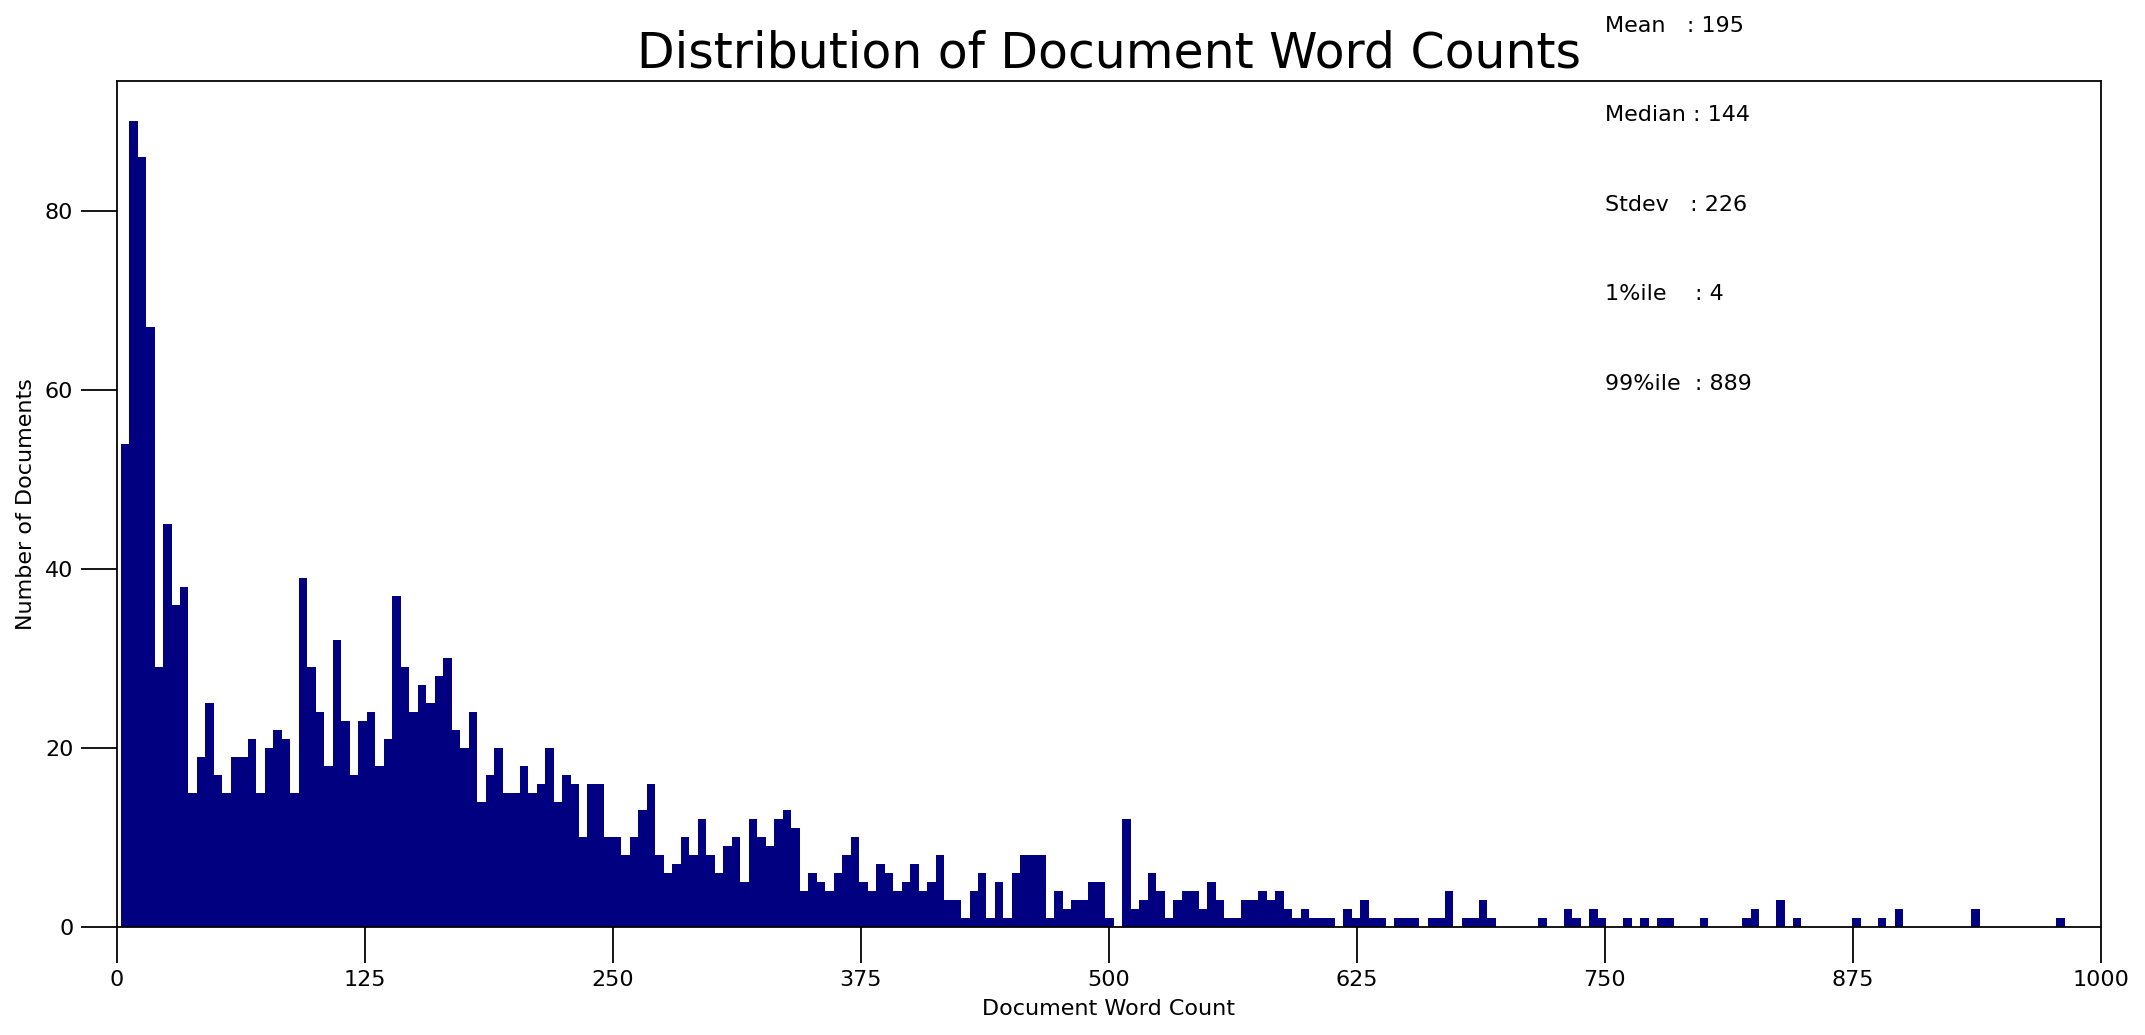

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

(array([ 4.,  6.,  5.,  8.,  4., 11., 11., 10.,  3.,  7.,  4.,  6.,  0.,
        11.,  2.,  8.,  5.,  3.,  5.,  2.,  5.,  4.,  3.,  0.,  3.,  1.,
         4.,  0.,  5.,  2.,  2.,  8.,  0.,  5.,  1.,  1.,  4.,  6.,  1.,
         4.,  0.,  3.,  3.,  5.,  2.,  4.,  6.,  2.,  6.,  3.,  2.,  4.,
         5.,  3.,  5.,  0.,  3.,  2.,  5.,  2.,  7.,  4.,  9.,  3.,  1.,
         6.,  0.,  5.,  2.,  3.,  1.,  8.,  1.,  5.,  3.,  4.,  1.,  3.,
         3.,  1.,  0.,  2.,  3.,  3.,  3.,  6.,  3.,  1.,  6.,  1.,  2.,
         4.,  6.,  3.,  3.,  7.,  2.,  5.,  2.,  6.,  1.,  3.,  2.,  4.,
         2.,  5.,  4.,  6.,  1.,  2.,  2.,  0.,  3.,  2.,  4.,  2.,  4.,
         4.,  1.,  1.,  3.,  0.,  4.,  1.,  2.,  1.,  1.,  1.,  1.,  3.,
         0.,  1.,  1.,  1.,  0.,  2.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  1.,  2.,  4.,  0.,  3.,  2.,  0.,  3.,  0.,  2.,  1.,
         0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  1.,  1.,  2.,  0.,  1.,  2.,  2.,  0.

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 0')

(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 1.,
        1., 0., 0., 1., 4., 2., 4., 2., 2., 0., 0., 3., 4., 2., 3., 6., 3.,
        3., 1., 3., 1., 3., 4., 0., 4., 3., 0., 0., 2., 0., 5., 2., 4., 7.,
        3., 2., 3., 1., 5., 5., 0., 2., 1., 4., 3., 2., 0., 1., 1., 2., 2.,
        3., 3., 1., 0., 8., 1., 3., 3., 2., 1., 3., 2., 3., 2., 2., 0., 1.,
        0., 6., 2., 2., 3., 1., 1., 1., 3., 0., 1., 1., 2., 1., 0., 1., 0.,
        0., 1., 0., 1., 4., 2., 3., 0., 2., 1., 2., 1., 1., 1., 1., 0., 8.,
        0., 2., 2., 1., 0., 2., 1., 1., 1., 1., 2., 0., 1., 0., 2., 2., 1.,
        1., 2., 0., 2., 0., 0., 1., 0., 0., 1., 3., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 3., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 1')

(array([13., 40., 37., 44., 36., 19., 23.,  6., 16., 20., 11., 15., 11.,
         6.,  7.,  2.,  6.,  5.,  5.,  5.,  2.,  3.,  3.,  3.,  4.,  3.,
         0.,  3.,  2.,  3.,  3.,  2.,  2.,  1.,  4.,  2.,  5.,  3.,  3.,
         2.,  0.,  2.,  2.,  4.,  2.,  6.,  2.,  2.,  1.,  3.,  0.,  3.,
         2.,  6.,  3.,  2.,  7.,  0.,  5.,  3.,  2.,  8.,  1.,  3.,  3.,
         1.,  4.,  2.,  4.,  0.,  1.,  2.,  5.,  3.,  3.,  3.,  1.,  2.,
         0.,  3.,  2.,  2.,  2.,  2.,  1.,  3.,  3.,  3.,  0.,  3.,  0.,
         2.,  5.,  0.,  1.,  1.,  4.,  1.,  2.,  2.,  0.,  2.,  3.,  2.,
         3.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  0.,  1.,  3.,  0.,  1.,
         1.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  2.,  1.,  3.,
         3.,  1.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,  2.,  2.,  0.,  1.,
         0.,  1.,  1.,  0.,  1.,  2.,  1.,  2.,  0.,  1.,  0.,  0.,  1.,
         1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  2.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  4.

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 2')

(array([3., 1., 0., 3., 0., 0., 2., 1., 2., 5., 1., 2., 0., 0., 1., 1., 0.,
        0., 5., 4., 2., 1., 1., 3., 1., 0., 2., 3., 1., 0., 0., 1., 2., 3.,
        2., 2., 1., 0., 1., 0., 2., 3., 5., 2., 3., 5., 1., 2., 3., 4., 7.,
        0., 8., 4., 5., 3., 1., 6., 6., 5., 1., 3., 3., 0., 5., 6., 3., 9.,
        3., 2., 0., 2., 5., 1., 5., 7., 2., 4., 4., 5., 1., 1., 1., 4., 4.,
        6., 4., 4., 6., 6., 4., 4., 6., 2., 1., 6., 1., 5., 5., 0., 2., 1.,
        4., 1., 5., 4., 4., 3., 2., 2., 4., 3., 3., 3., 4., 3., 2., 2., 4.,
        1., 2., 1., 3., 2., 2., 1., 2., 2., 1., 0., 3., 5., 1., 1., 2., 3.,
        2., 3., 1., 1., 3., 0., 1., 1., 0., 2., 3., 0., 4., 3., 1., 0., 1.,
        0., 3., 1., 0., 2., 1., 1., 0., 2., 0., 0., 0., 1., 0., 1., 3., 4.,
        2., 0., 0., 0., 2., 1., 4., 1., 1., 1., 3., 1., 2., 2., 3., 4., 0.,
        1., 2., 2., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 3., 0., 0., 0.,
        5., 1., 1., 0., 0., 2., 0., 0., 0., 1., 1., 0., 2., 0., 0., 2., 1.,
        1., 

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 3')

([<matplotlib.axis.XTick at 0x7f682f1cd890>,
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 0.98, 'Distribution of Document Word Counts by Dominant Topic')

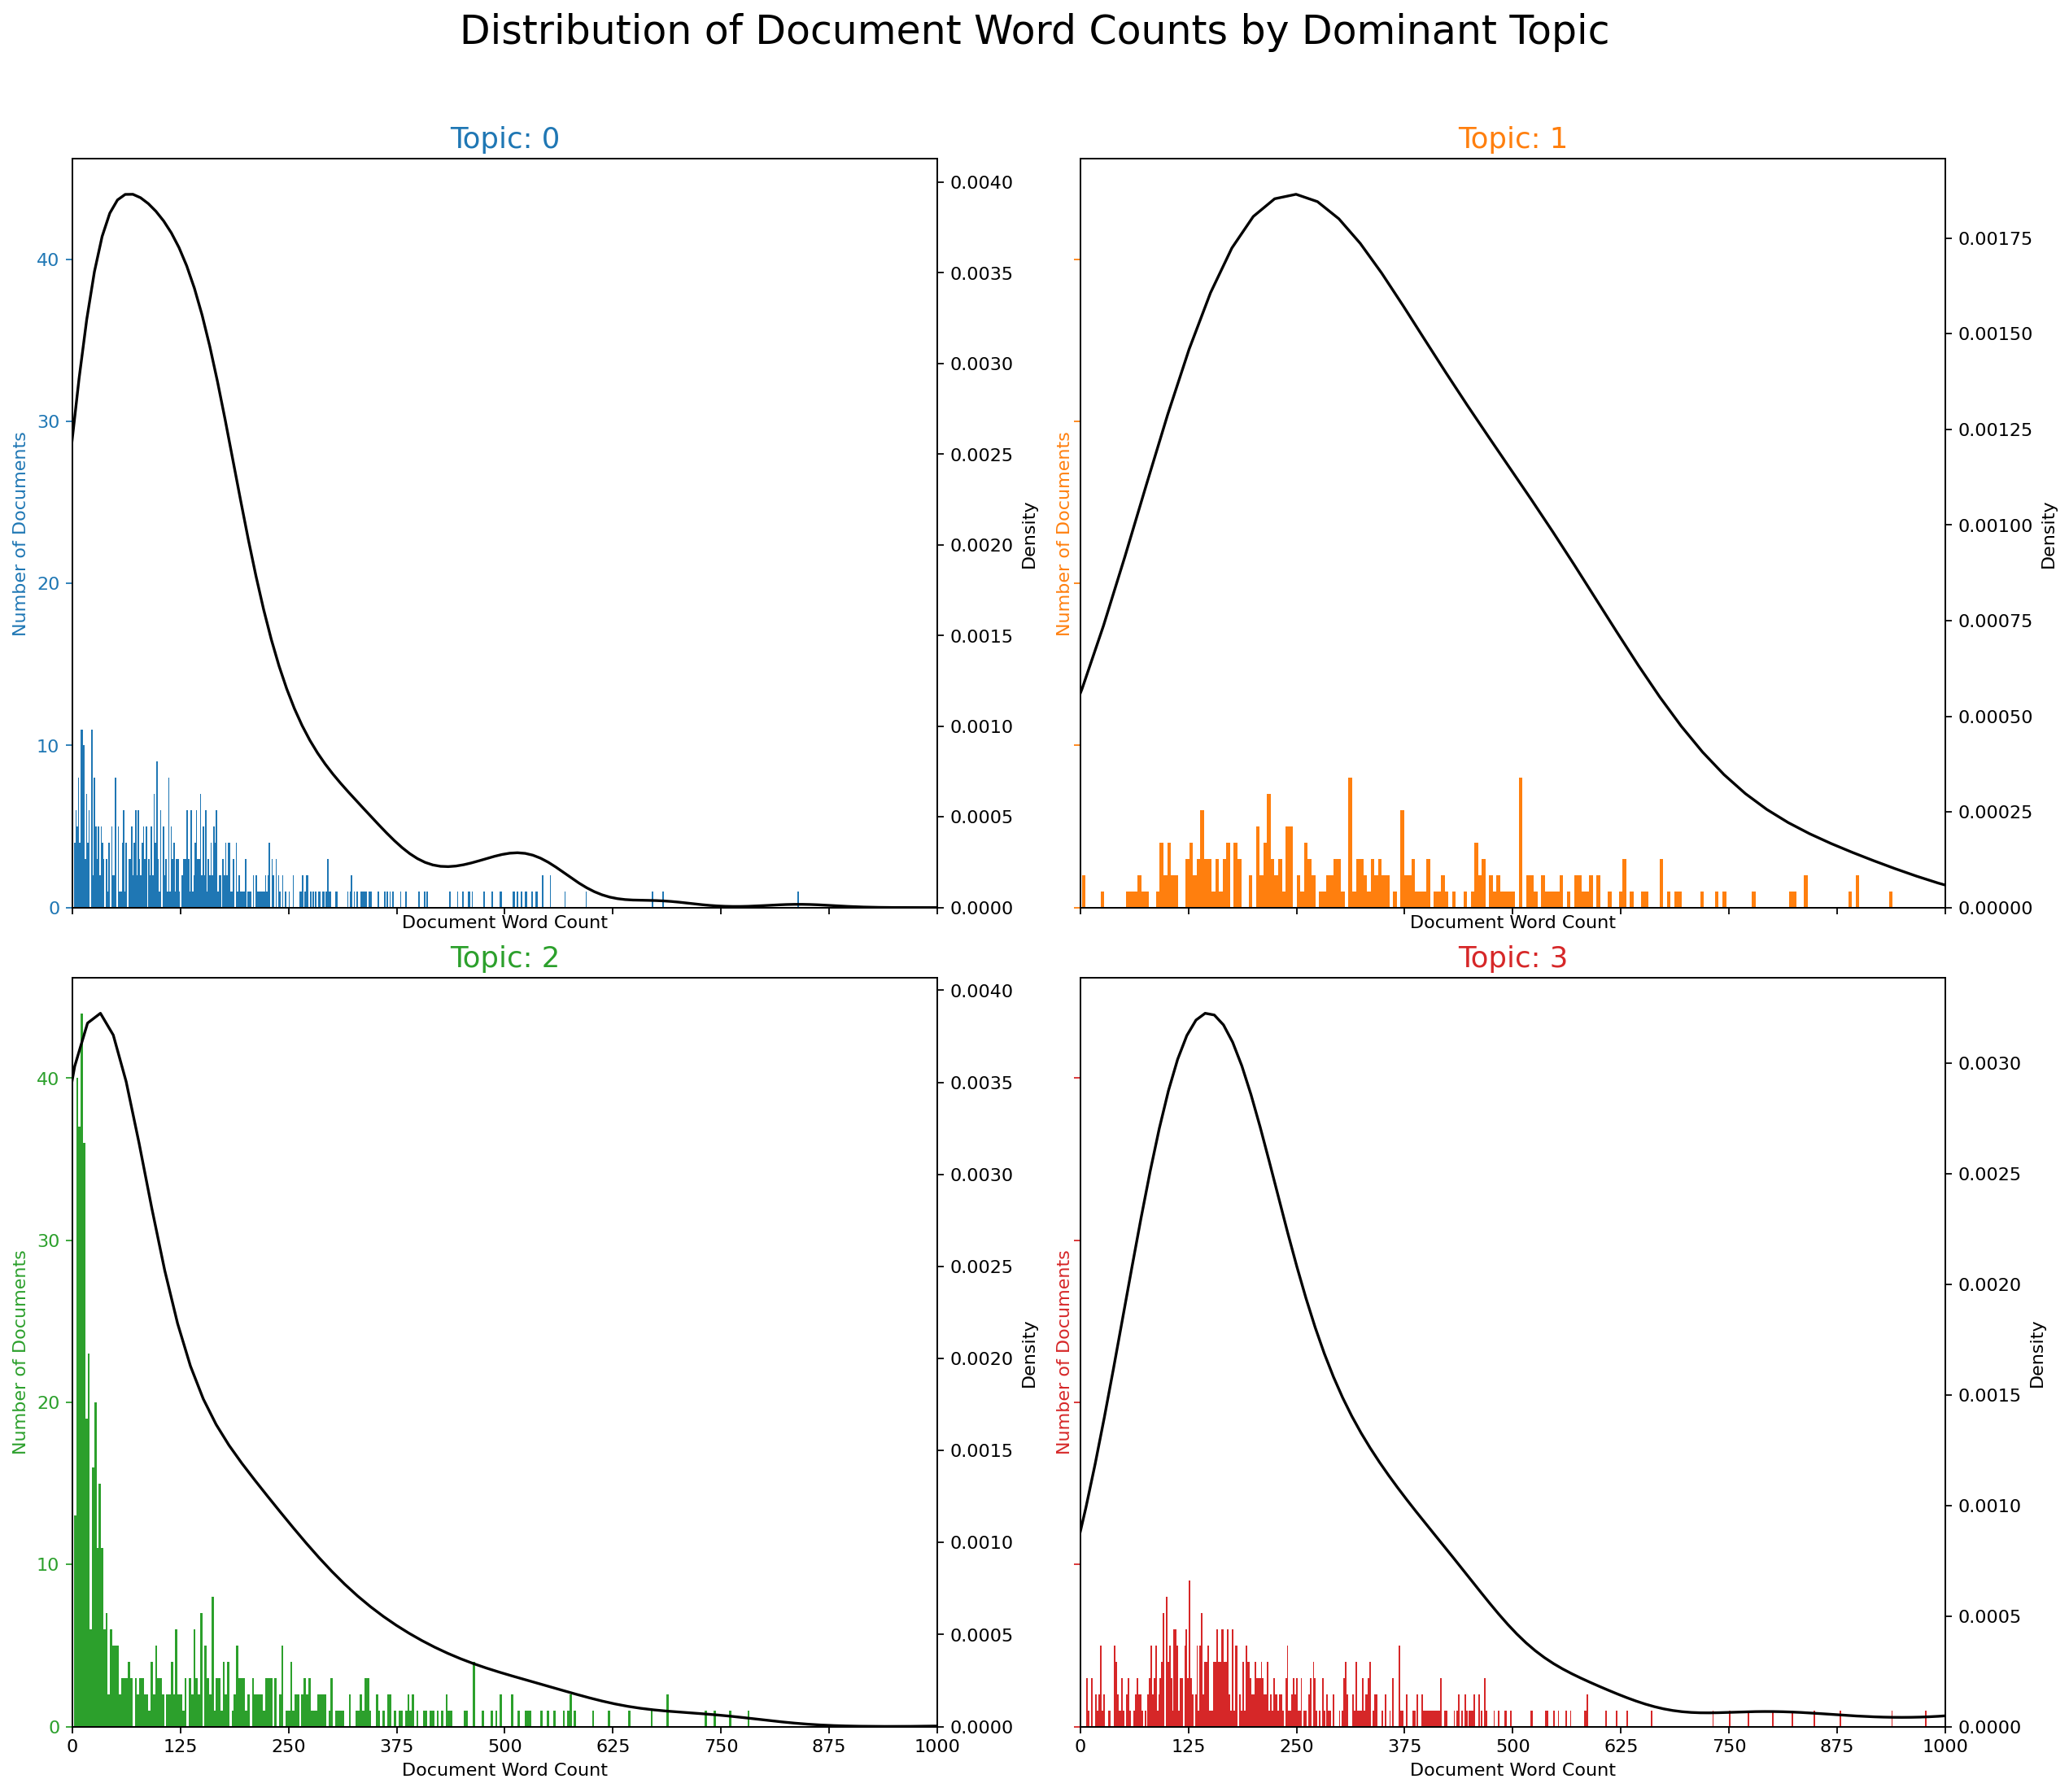

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

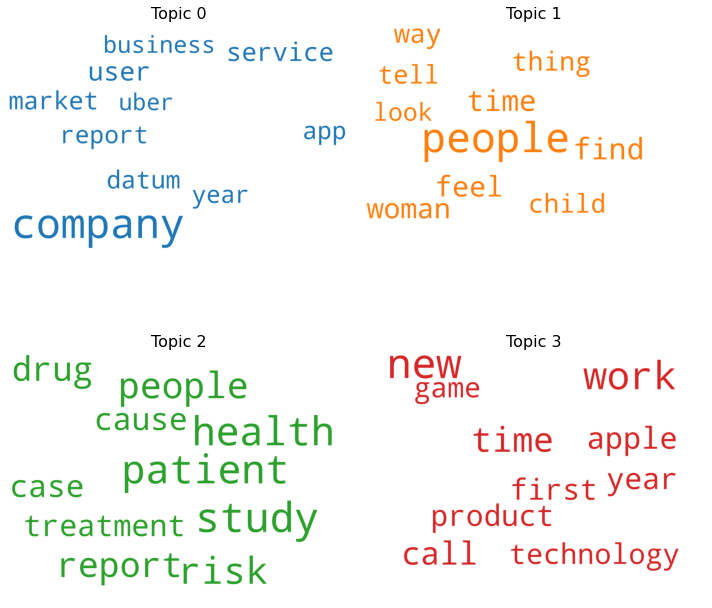

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'company'),
 Text(0, 0, 'user'),
 Text(0, 0, 'service'),
 Text(0, 0, 'market'),
 Text(0, 0, 'datum'),
 Text(0, 0, 'app'),
 Text(0, 0, 'report'),
 Text(0, 0, 'year'),
 Text(0, 0, 'business'),
 Text(0, 0, 'uber')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'people'),
 Text(0, 0, 'find'),
 Text(0, 0, 'time'),
 Text(0, 0, 'feel'),
 Text(0, 0, 'woman'),
 Text(0, 0, 'thing'),
 Text(0, 0, 'way'),
 Text(0, 0, 'child'),
 Text(0, 0, 'tell'),
 Text(0, 0, 'look')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'study'),
 Text(0, 0, 'patient'),
 Text(0, 0, 'health'),
 Text(0, 0, 'risk'),
 Text(0, 0, 'people'),
 Text(0, 0, 'report'),
 Text(0, 0, 'drug'),
 Text(0, 0, 'cause'),
 Text(0, 0, 'case'),
 Text(0, 0, 'treatment')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'new'),
 Text(0, 0, 'work'),
 Text(0, 0, 'time'),
 Text(0, 0, 'call'),
 Text(0, 0, 'apple'),
 Text(0, 0, 'year'),
 Text(0, 0, 'product'),
 Text(0, 0, 'first'),
 Text(0, 0, 'technology'),
 Text(0, 0, 'game')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

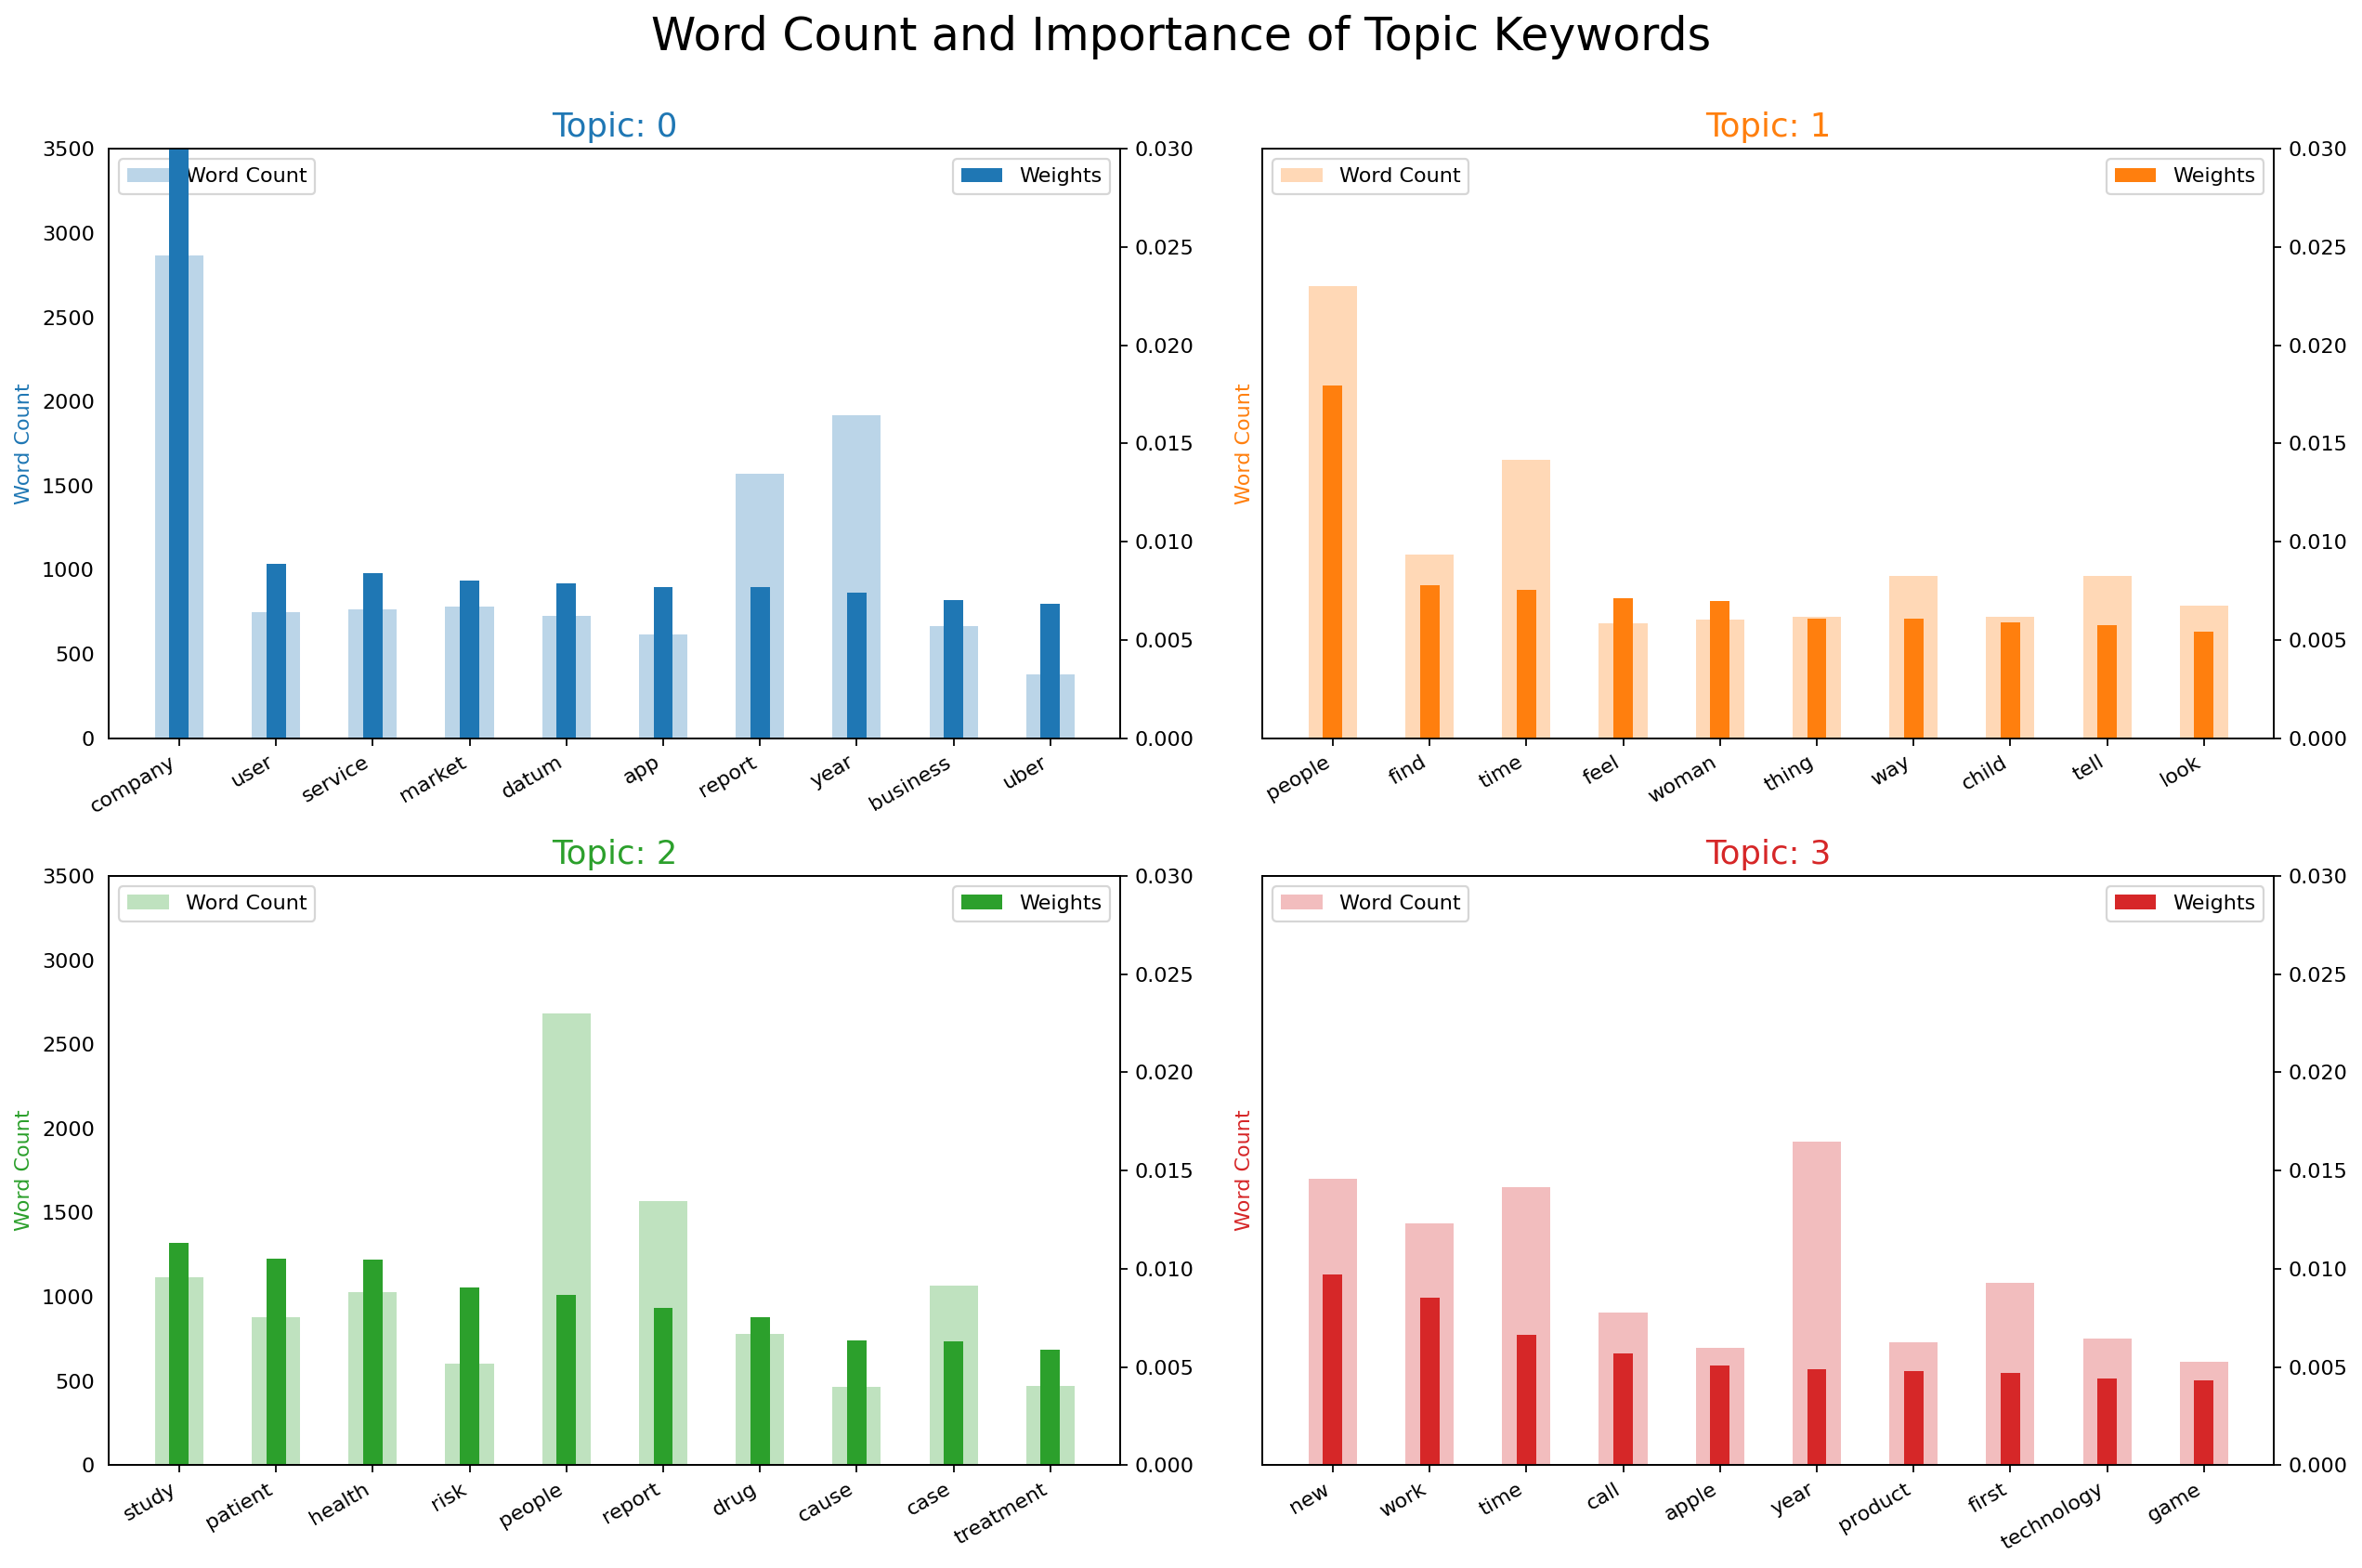

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

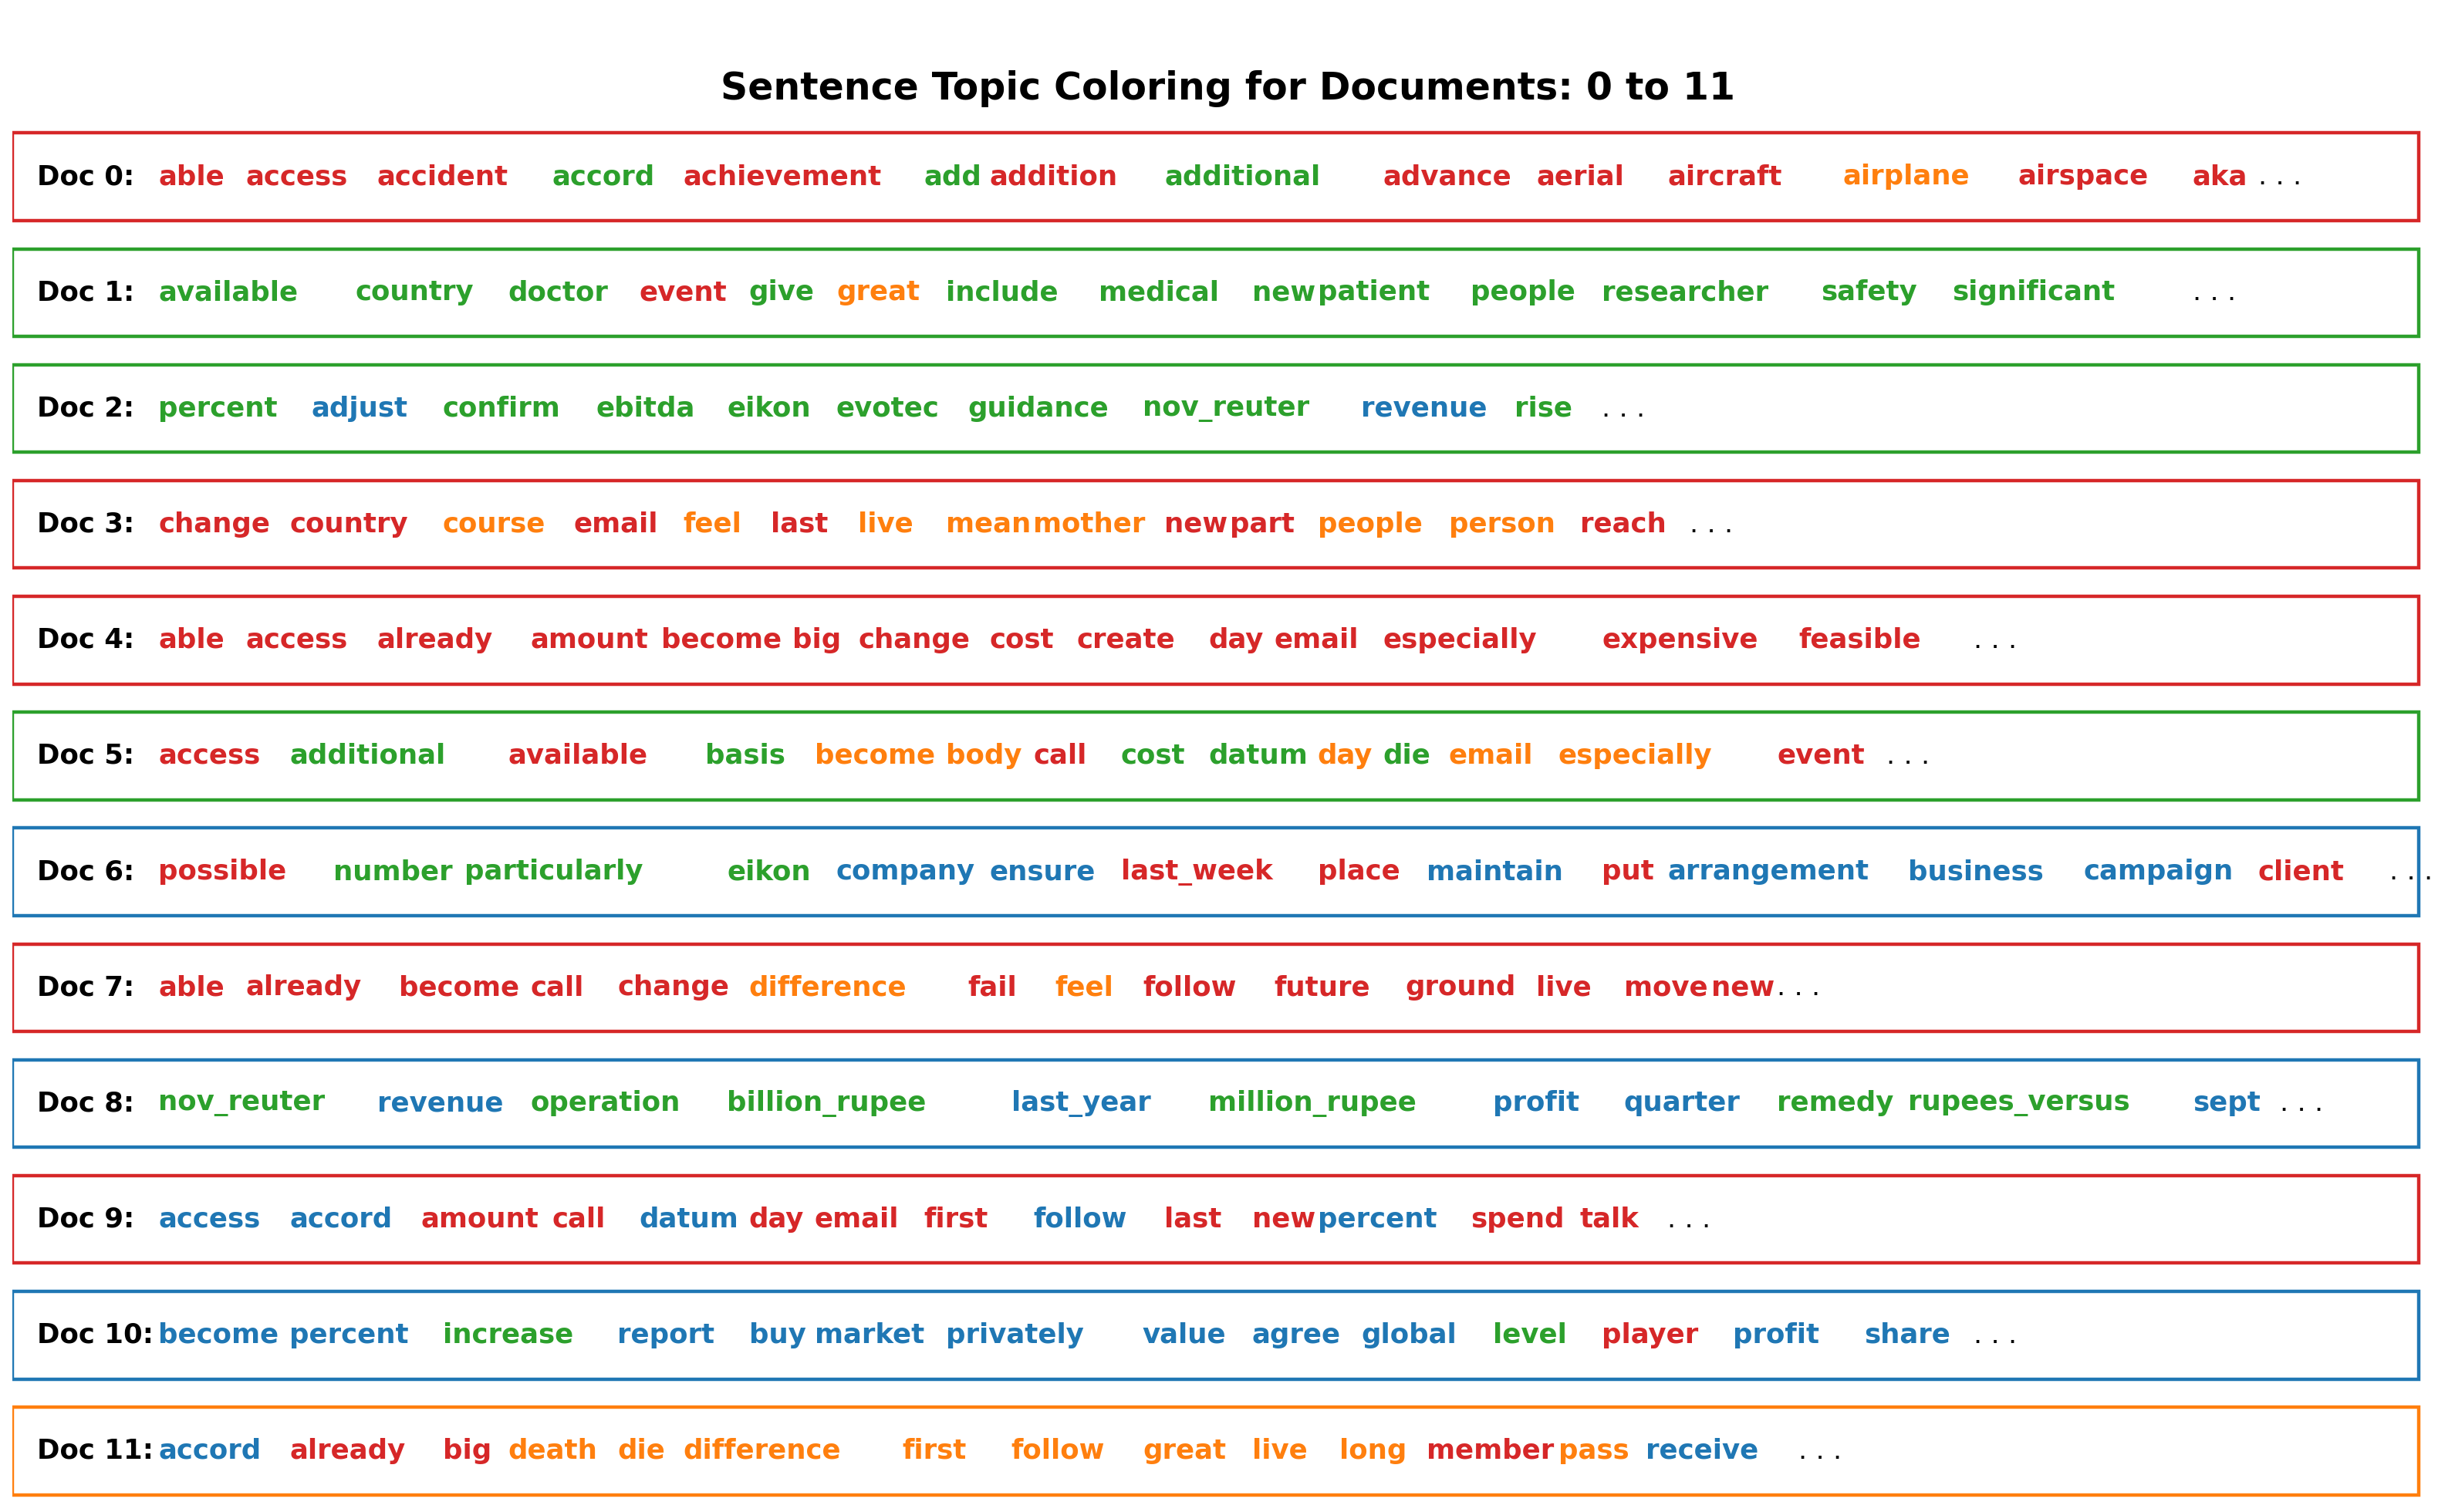

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Number of Documents by Dominant Topic')

Text(0, 0.5, 'Number of Documents')

(0.0, 1000.0)

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

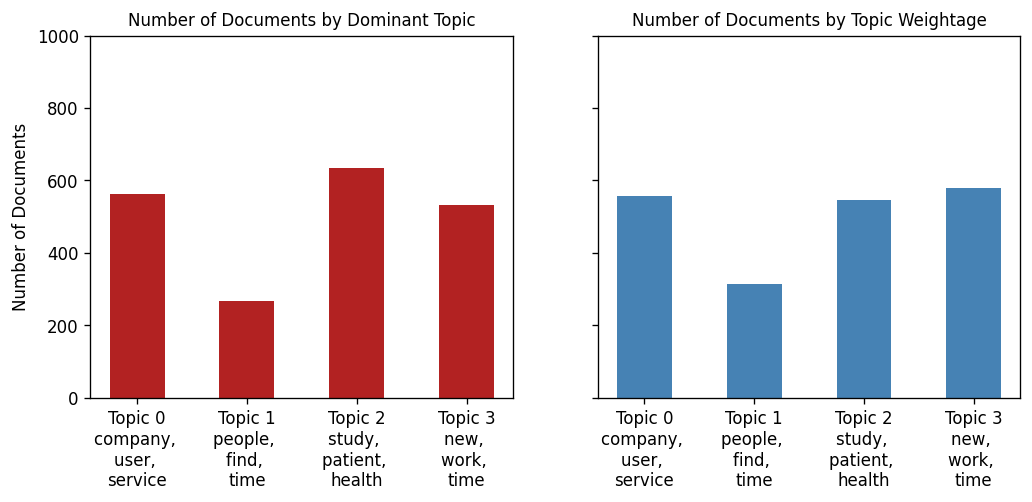

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1964 samples in 0.002s...
[t-SNE] Computed neighbors for 1964 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1964
[t-SNE] Computed conditional probabilities for sample 1964 / 1964
[t-SNE] Mean sigma: 0.054625
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.666328
[t-SNE] KL divergence after 1000 iterations: 0.631151


GlyphRenderer(id='1038', ...)

In [ ]:
#!pip install pyLDAvis
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=168c722d6fcb656bb04bd63ff8d10b03d0ae285253024cd9d3b96a007fd3c8f4
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=802c29eefc2647454aaccd401d0d4f658f9b04550d21a4f646b01731dec3bb64
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.160122  0.031281       1        1  32.984131
1      0.168191 -0.141955       2        1  24.612007
0     -0.271390 -0.117344       3        1  22.605559
2     -0.056923  0.228018       4        1  19.798303, topic_info=         Term         Freq        Total Category  logprob  loglift
511   company  2857.000000  2857.000000  Default  30.0000  30.0000
169   patient   812.000000   812.000000  Default  29.0000  29.0000
790    health   807.000000   807.000000  Default  28.0000  28.0000
373     study  1107.000000  1107.000000  Default  27.0000  27.0000
699      user   781.000000   781.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
115   include   368.706652  1233.793036   Topic4  -5.3424   0.4117
154       new   403.063845  1838.989740   Topic4  -5.2533   0.1017
276      year   345.116745  1703.191490   Topic4  -5.4085   0.0232
652  research   271.058444   564.333382   Topic4  -5.6501   0.8863
984   product   268.576637   886.182735   Topic4  -5.6593   0.4258

[257 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3         1  0.132804    accord
3         2  0.008780    accord
3         3  0.398413    accord
3         4  0.459876    accord
2458      1  0.994820  activity
...     ...       ...       ...
276       3  0.383398      year
276       4  0.202561      year
473       2  0.993947     young
3191      3  0.997577   youtube
4953      4  0.992588      zika

[353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

## Acknowledgements

- The code get_top_n_bigram is adapted from [topic modeling](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)